In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, roc_auc_score ,classification_report ,accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , FunctionTransformer
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier,StackingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("cardio_cleaned.csv")

In [3]:
skew_vals = df.skew().sort_values(ascending=False)
print(skew_vals)


gluc              2.398311
lifestyle_risk    2.025072
cholesterol       1.586569
pulse_pressure    1.002736
BMI               0.895980
ap_hi             0.696141
gender            0.631068
weight            0.565632
ap_lo             0.166174
height            0.086342
cardio            0.002664
age              -0.307085
ap_status        -0.663584
dtype: float64


## Logistic Regression

Train Accuracy: 0.7302775290957924
Test Accuracy: 0.7313614552746545

Train Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.80      0.75     27962
           1       0.77      0.66      0.71     27888

    accuracy                           0.73     55850
   macro avg       0.73      0.73      0.73     55850
weighted avg       0.73      0.73      0.73     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.80      0.75      6991
           1       0.77      0.66      0.71      6972

    accuracy                           0.73     13963
   macro avg       0.74      0.73      0.73     13963
weighted avg       0.74      0.73      0.73     13963

Train AUC: 0.7301837731955133
Test AUC: 0.7312618477670618


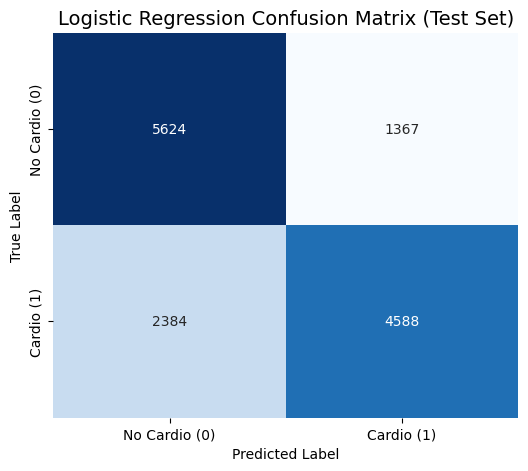

In [4]:
x = df.drop(["cardio"], axis = 1)
y = df["cardio"]
x_train , x_test , y_train , y_test = train_test_split(
    x,
    y, 
    test_size = 0.2,
    random_state = 42,
    stratify= y,
    shuffle = True
    )

skewed_cols = ["ap_hi", "ap_lo", "BMI", "pulse_pressure","height","weight"]
scaled_cols = ["age", "ap_hi", "ap_lo", "BMI", "pulse_pressure","height","weight",]

preprocess = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, validate=False), skewed_cols),
        ("scale", StandardScaler(), scaled_cols)
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("log_reg", LogisticRegression(max_iter = 3000,random_state = 42)),
])

pipe.fit(x_train,y_train)
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Logistic Regression"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Logistic Regression Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Descision Tree

Train Accuracy: 0.8094180841539839
Test Accuracy: 0.7920217718255389

Train Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.89      0.82     27962
           1       0.87      0.73      0.79     27888

    accuracy                           0.81     55850
   macro avg       0.82      0.81      0.81     55850
weighted avg       0.82      0.81      0.81     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.87      0.81      6991
           1       0.85      0.71      0.77      6972

    accuracy                           0.79     13963
   macro avg       0.80      0.79      0.79     13963
weighted avg       0.80      0.79      0.79     13963

Train AUC: 0.8093113241485054
Test AUC: 0.7919136032861857


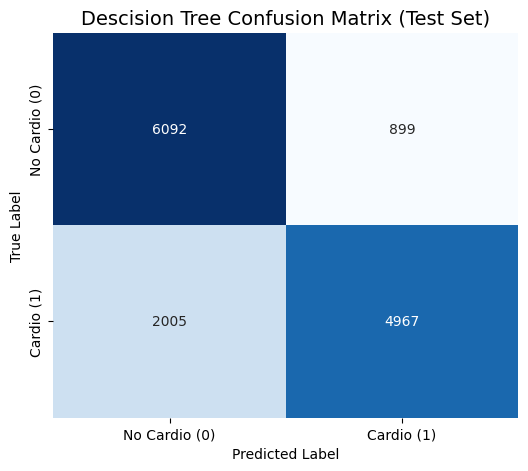

In [5]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("tree", DecisionTreeClassifier(
        criterion="gini",
        max_depth=15,
        min_samples_split=10,
        random_state=42
    ))
])

pipe.fit(x_train,y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

tree_metrics = pd.DataFrame({
    "Model": ["Decision Tree", "Decision Tree"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Descision Tree Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Train Accuracy: 0.8054968666069829
Test Accuracy: 0.8006875313328081

Train Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.91      0.82     27962
           1       0.89      0.70      0.78     27888

    accuracy                           0.81     55850
   macro avg       0.82      0.81      0.80     55850
weighted avg       0.82      0.81      0.80     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.91      0.82      6991
           1       0.88      0.70      0.78      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.80535866554696
Test AUC: 0.8005441981670885


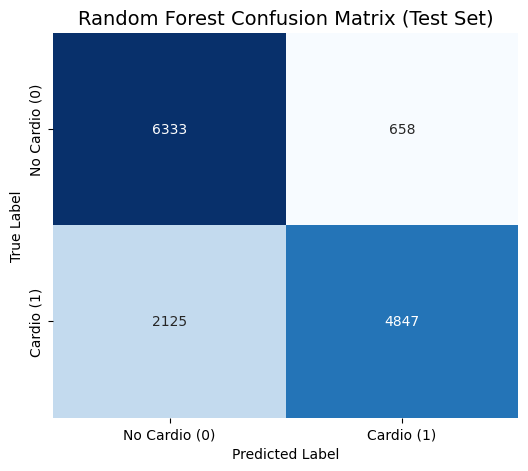

In [6]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("forest", RandomForestClassifier(
        n_estimators=200,      
        criterion="gini",       
        max_depth=12,           
        min_samples_split=10,   
        random_state=42,
        n_jobs=-1              
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


rf_metrics = pd.DataFrame({
    "Model": ["Random Forest", "Random Forest"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Random Forest Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Gradient Boosting

Train Accuracy: 0.7987466427931961
Test Accuracy: 0.8021198882761584

Train Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.89      0.82     27962
           1       0.87      0.71      0.78     27888

    accuracy                           0.80     55850
   macro avg       0.81      0.80      0.80     55850
weighted avg       0.81      0.80      0.80     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.90      0.82      6991
           1       0.87      0.71      0.78      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.7986237792474936
Test AUC: 0.8019929299313033


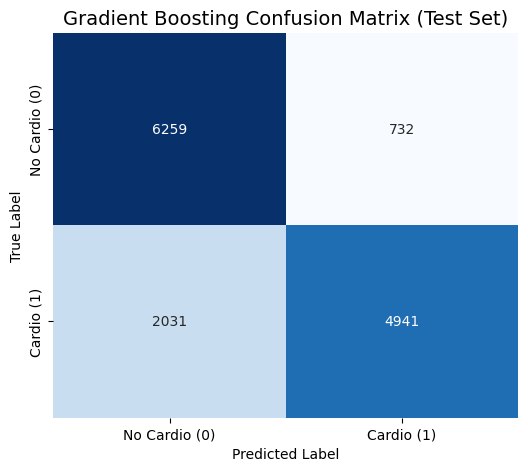

In [7]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("gb", GradientBoostingClassifier(
        n_estimators=300,       
        learning_rate=0.05,     
        min_samples_split=10,   
        random_state=42
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

gb_metrics = pd.DataFrame({
    "Model": ["Gradient Boosting", "Gradient Boosting"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Gradient Boosting Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## XG Boost

Train Accuracy: 0.8115846016114593
Test Accuracy: 0.802477977511996

Train Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.90      0.83     27962
           1       0.87      0.73      0.79     27888

    accuracy                           0.81     55850
   macro avg       0.82      0.81      0.81     55850
weighted avg       0.82      0.81      0.81     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.89      0.82      6991
           1       0.86      0.72      0.78      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.8114734564875214
Test AUC: 0.8023626167830076


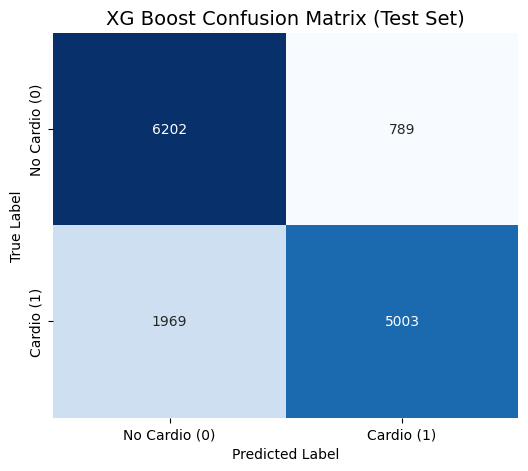

In [8]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("xgb", XGBClassifier(
        n_estimators=300,        
        learning_rate=0.05,      
        max_depth=6,             
        min_child_weight=5,      
        subsample=0.8,           
        colsample_bytree=0.8,    
        eval_metric="logloss",  
        random_state=42,
        n_jobs=-1,
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


xgb_metrics = pd.DataFrame({
    "Model": ["XGBoost", "XGBoost"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("XG Boost Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## LGBM

[LightGBM] [Info] Number of positive: 27888, number of negative: 27962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 55850, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499338 -> initscore=-0.002650
[LightGBM] [Info] Start training from score -0.002650


d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.8265890778871978
Test Accuracy: 0.7994700279309604

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.91      0.84     27962
           1       0.89      0.75      0.81     27888

    accuracy                           0.83     55850
   macro avg       0.84      0.83      0.83     55850
weighted avg       0.84      0.83      0.83     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.88      0.81      6991
           1       0.86      0.72      0.78      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.8264813753465843
Test AUC: 0.799359534301663


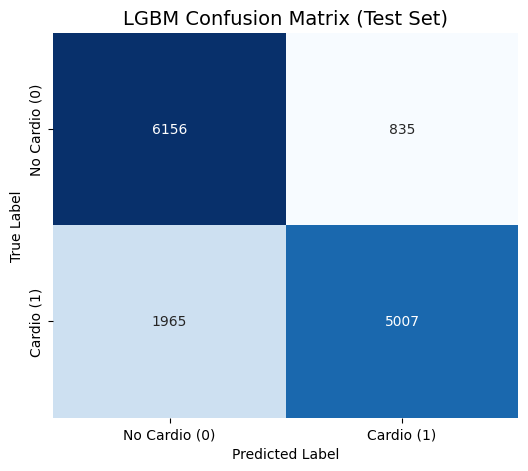

In [9]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("lgbm", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


lgbm_metrics = pd.DataFrame({
    "Model": ["LightGBM", "LightGBM"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("LGBM Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Cat Boost

Train Accuracy: 0.8092211280214862
Test Accuracy: 0.8032657738308386

Train Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.89      0.82     27962
           1       0.87      0.73      0.79     27888

    accuracy                           0.81     55850
   macro avg       0.82      0.81      0.81     55850
weighted avg       0.82      0.81      0.81     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.89      0.82      6991
           1       0.86      0.72      0.79      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.8091106430175729
Test AUC: 0.8031520712680914


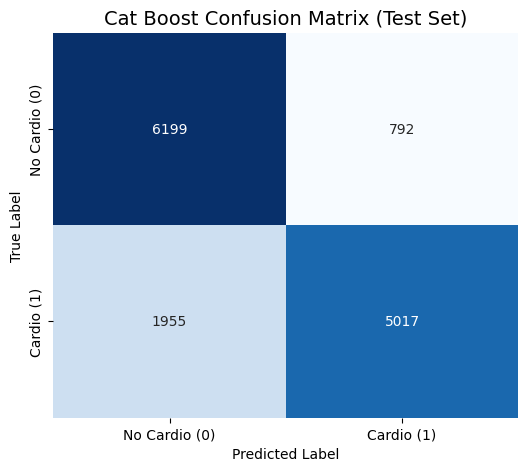

In [10]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("cat", CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        subsample=0.8,
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    ))
])

pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

cat_metrics = pd.DataFrame({
    "Model": ["CatBoost", "CatBoost"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Cat Boost Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

d:\Anaconda\envs\depi\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.8095613249776186
Test Accuracy: 0.8010456205686457

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.87      0.82     27962
           1       0.85      0.75      0.80     27888

    accuracy                           0.81     55850
   macro avg       0.81      0.81      0.81     55850
weighted avg       0.81      0.81      0.81     55850

Test Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.86      0.81      6991
           1       0.84      0.74      0.79      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963

Train AUC: 0.8094808987551871
Test AUC: 0.8009604677368566


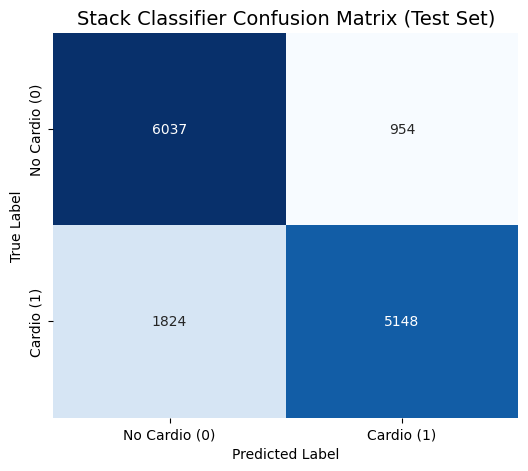

In [11]:
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
    random_state=42, n_jobs=-1, use_label_encoder=False
)

lgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)

cat = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6,
    l2_leaf_reg=3, subsample=0.8, eval_metric="AUC",
    random_seed=42, verbose=False
)

meta_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)


stack = StackingClassifier(
    estimators=[
        ("xgb", xgb),
        ("lgbm", lgbm),
        ("cat", cat)
    ],
    final_estimator=meta_model,
    passthrough=True, 
    n_jobs=-1
)


pipe = Pipeline([
    ("preprocess", preprocess),
    ("stack", stack)
])


pipe.fit(x_train, y_train)


y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


ensemble_metrics = pd.DataFrame({
    "Model": ["Stacked Ensemble", "Stacked Ensemble"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Stack Classifier Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:

metrics = pd.concat([
    tree_metrics,
    rf_metrics,
    gb_metrics,
    xgb_metrics,
    lgbm_metrics,
    cat_metrics,
    ensemble_metrics
], ignore_index=True)


metrics

,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,Train,0.809418,0.868430,0.728736,0.792474,0.809311
1,Decision Tree,Test,0.792022,0.846744,0.712421,0.773797,0.791914
2,Random Forest,Train,0.805497,0.885582,0.701054,0.782588,0.805359
3,Random Forest,Test,0.800688,0.880472,0.695209,0.776950,0.800544
4,Gradient Boosting,Train,0.798747,0.866309,0.705895,0.777918,0.798624
5,Gradient Boosting,Test,0.802120,0.870968,0.708692,0.781495,0.801993
6,XGBoost,Train,0.811585,0.873972,0.727589,0.794091,0.811473
7,XGBoost,Test,0.802478,0.863778,0.717585,0.783924,0.802363
8,LightGBM,Train,0.826589,0.889602,0.745195,0.811021,0.826481
9,LightGBM,Test,0.799470,0.857069,0.718158,0.781489,0.799360


## Optimization for Stacked ensmble model as it has the best recall

Fitting 3 folds for each of 20 candidates, totalling 60 fits


d:\Anaconda\envs\depi\lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🧩 Best Parameters Found:

                            Parameter  Best Value
                    stack__cat__depth    6.000000
            stack__cat__learning_rate    0.118323
stack__final_estimator__learning_rate    0.066676
    stack__final_estimator__max_depth    2.000000
           stack__lgbm__learning_rate    0.080754
              stack__lgbm__num_leaves   40.000000
            stack__xgb__learning_rate    0.065050
                stack__xgb__max_depth    4.000000


d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Performance Summary:

Dataset                    Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
  Train Optimized Stack Ensemble  0.810492   0.867795 0.731999  0.794134 0.810389
   Test Optimized Stack Ensemble  0.803123   0.860632 0.722748  0.785686 0.803013

--- Train Classification Report ---

              precision    recall  f1-score   support

           0       0.77      0.89      0.82     27962
           1       0.87      0.73      0.79     27888

    accuracy                           0.81     55850
   macro avg       0.82      0.81      0.81     55850
weighted avg       0.82      0.81      0.81     55850


--- Test Classification Report ---

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      6991
           1       0.86      0.72      0.79      6972

    accuracy                           0.80     13963
   macro avg       0.81      0.80      0.80     13963
weighted avg       0.81      0.80      0.80     13963



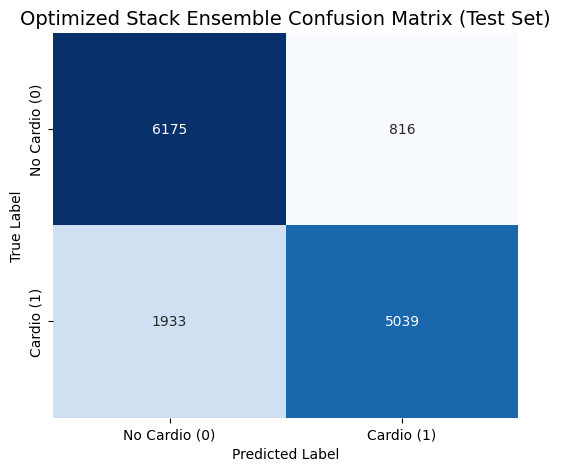

In [ ]:
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", random_state=42,
    n_jobs=-1, use_label_encoder=False
)

lgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1
)

cat = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6,
    l2_leaf_reg=3, subsample=0.8,
    eval_metric="AUC", random_seed=42, verbose=False
)


meta_model = XGBClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", random_state=42,
    n_jobs=-1, use_label_encoder=False
)


stack = StackingClassifier(
    estimators=[
        ("xgb", xgb),
        ("lgbm", lgbm),
        ("cat", cat)
    ],
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)


pipe = Pipeline([
    ("preprocess", preprocess),
    ("stack", stack)
])


param_distributions = {
    "stack__xgb__max_depth": randint(3, 8),
    "stack__xgb__learning_rate": uniform(0.02, 0.1),
    "stack__lgbm__num_leaves": randint(20, 50),
    "stack__lgbm__learning_rate": uniform(0.02, 0.1),
    "stack__cat__depth": randint(4, 8),
    "stack__cat__learning_rate": uniform(0.02, 0.1),

    "stack__final_estimator__max_depth": randint(2, 5),
    "stack__final_estimator__learning_rate": uniform(0.02, 0.1)
}


random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,                
    scoring="recall",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


random_search.fit(x_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_


best_params_df = pd.DataFrame(best_params.items(), columns=["Parameter", "Best Value"])
print("\n Best Parameters Found:\n")
print(best_params_df.to_string(index=False))


y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)


ensemble_opt_metrics = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Model": ["Optimized Stack Ensemble", "Optimized Stack Ensemble"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    "Precision": [
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)
    ],
    "Recall": [
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)
    ],
    "F1 Score": [
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)
    ],
    "ROC-AUC": [
        roc_auc_score(y_train, y_train_pred),
        roc_auc_score(y_test, y_test_pred)
    ]
})

print("\n📊 Performance Summary:\n")
print(ensemble_opt_metrics.to_string(index=False))


print("\n--- Train Classification Report ---\n")
print(classification_report(y_train, y_train_pred))
print("\n--- Test Classification Report ---\n")
print(classification_report(y_test, y_test_pred))


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Optimized Stack Ensemble Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()





# Normal Stacked Ensmble is the most efective model having 74% recall and 79% f1 score

In [20]:

metrics = pd.concat([metrics , ensemble_opt_metrics],ignore_index= True)
metrics

,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,Train,0.809418,0.868430,0.728736,0.792474,0.809311
1,Decision Tree,Test,0.792022,0.846744,0.712421,0.773797,0.791914
2,Random Forest,Train,0.805497,0.885582,0.701054,0.782588,0.805359
3,Random Forest,Test,0.800688,0.880472,0.695209,0.776950,0.800544
4,Gradient Boosting,Train,0.798747,0.866309,0.705895,0.777918,0.798624
5,Gradient Boosting,Test,0.802120,0.870968,0.708692,0.781495,0.801993
6,XGBoost,Train,0.811585,0.873972,0.727589,0.794091,0.811473
7,XGBoost,Test,0.802478,0.863778,0.717585,0.783924,0.802363
8,LightGBM,Train,0.826589,0.889602,0.745195,0.811021,0.826481
9,LightGBM,Test,0.799470,0.857069,0.718158,0.781489,0.799360


In [21]:
metrics.to_csv("Models_Metrics.csv")
